In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, 
                             precision_score,
                             recall_score)
from model_validation import *

Functions

In [37]:
def get_WOEs(X, y, decimal=4):
    WOE = X.copy()
    mapping = dict()
    N = np.r_[sum(y==0), sum(y)]
    for var in X.columns:
        x = WOE[var].values.copy()
        values = np.unique(x)
        if len(values)>1:
            dok = dict()
            for v in values:
                if v==1:
                    n = np.array([sum(y[x==v]==m) for m in [0,1]])
                    dist_good = np.fmax(n[0],1)/N[0]
                    dist_bad  = np.fmax(n[1],1)/N[1]
                    woe = np.log(dist_good/dist_bad)*100
                    dok.update({1:min(np.round(woe, decimal),0)})
                else: dok.update({0:0})
            WOE[var] = WOE[var].apply(lambda x: dok[x])
            mapping.update({var:dok})
    return WOE, mapping

In [3]:
def map_WOEs(X, mapping):
    WOE = X.copy()
    columns = list(mapping.keys())
    for var in mapping.keys():
        WOE[var] = WOE[var].apply(lambda x: mapping[var][x])
    return WOE

In [4]:
def prec_recall(y_true, y_pred0, y_pred1):
    def fmt(x):
        x = '{:.2%}'.format(x)
        return str(x).rjust(max(len(x),7), " ")
    p0 = fmt(precision_score(y_true, y_pred0))
    p1 = fmt(precision_score(y_true, y_pred1))
    r0 = fmt(recall_score(y_true, y_pred0))
    r1 = fmt(recall_score(y_true, y_pred1))
    print('Precision => Before : {} , After : {}'.format(p0,p1))
    print('Recall    => Before : {} , After : {}'.format(r0,r1))

In [5]:
def cal_score(proba, pdo=20, odd=1., point=200., decimal=0, 
              min_prob=0.0001, max_prob=0.9999):
    proba_ = np.clip(proba, min_prob, max_prob)
    ln_odd = np.log([p/(1-p) for p in proba_])
    factor = pdo/np.log(2)
    offset = point - factor*np.log(odd)
    return (np.round_(offset+factor*ln_odd, decimal), 
            factor, offset)

In [6]:
evaluation = eval_classifier(n_columns=2,
                             plots=["f1","gini","hist","gain"],
                             ax_dict={"hist":{"bins":20, "use_kde":False}})

In [7]:
os.listdir()

['.ipynb_checkpoints',
 'assoc_rules_data_cut_to_75rules.txt',
 'Debit_Score_woe.ipynb',
 'model_validation-main',
 'model_validation.py',
 'model_validation_colab.ipynb',
 '__pycache__']

In [8]:
df = pd.read_csv("assoc_rules_data_cut_to_75rules.txt", sep="|")
rules = list(set(list(df)).difference(['f_fraud','month_id','data_split']))

In [9]:
df.head()

,f_fraud,month_id,data_split,ATM0001,ATM0002.2,ATM0004,ATM0006,ATM0008,ATM0010,ATM0060,...,EDC0102.2,PGW0012.6_Debit,PGW0012.6_Debit_Reject,PGW0031.2,PGW0032.2,PGW0034.2,PGW0049.2,VVIP_Broad_001.2,VVIP_Broad_002.2,WLST0013.2
0,0,2020-10,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,2020-10,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,2020-10,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,2020-11,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,2020-11,train_test,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Split train and test datasets

In [10]:
X = df.loc[df["data_split"]=='train_test', rules].copy()
y = df.loc[df["data_split"]=='train_test', 'f_fraud'].copy()

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [12]:
X_oot = df.loc[df["data_split"]=='out_of_time', rules].copy()
y_oot = df.loc[df["data_split"]=='out_of_time', 'f_fraud'].copy()

Weight of Evidence (WOE)

In [39]:
woe_train, mapping = get_WOEs(X_train, y_train)

mapping WOEs

In [40]:
woe_test = map_WOEs(X_test, mapping)
woe_oot  = map_WOEs(X_oot , mapping)

Running model (LogisticRegression)

In [83]:
features = np.array(list(woe_train))
i = 0
while True:
    i += 1
    print("Iteration:",i)
    model = LogisticRegression(max_iter=1000, class_weight="balanced", fit_intercept=False)
    model.fit(woe_train[features], y_train)
    used_features = features[model.coef_.ravel()>0]
    if len(used_features)<len(features): 
        features = used_features
    else: break
print("--Complete--")

Iteration: 1
Iteration: 2
--Complete--


In [84]:
used_features

array(['ECOM058.2', 'ECOM045.2', 'ECOM018.2', 'ECOM020.2', 'ECOM003',
       'ECOM029.2', 'ECOM038.2', 'ECOM057.2', 'ECOM034.2', 'ECOM066.2',
       'ECOM023.2', 'ECOM063.2', 'ECOM035.2', 'ECOM074.2', 'PGW0034.2',
       'ECOM019.2', 'ECOM059.2', 'ECOM010.R', 'ECOM010.2'], dtype='<U22')

Predictions

In [85]:
y_train_pred = model.predict_proba(woe_train[used_features])[:,1]
y_test_pred = model.predict_proba(woe_test[used_features])[:,1]
y_oot_pred = model.predict_proba(woe_oot[used_features])[:,1]

Observe model performance

D:\Users\danusorn.s\OneDrive - KASIKORNBANKGROUP\Desktop\Work\Python Projects\Rules\model_validation.py:322: RuntimeWarning: invalid value encountered in true_divide
  f1_score = 2*(p*r) / (p+r)


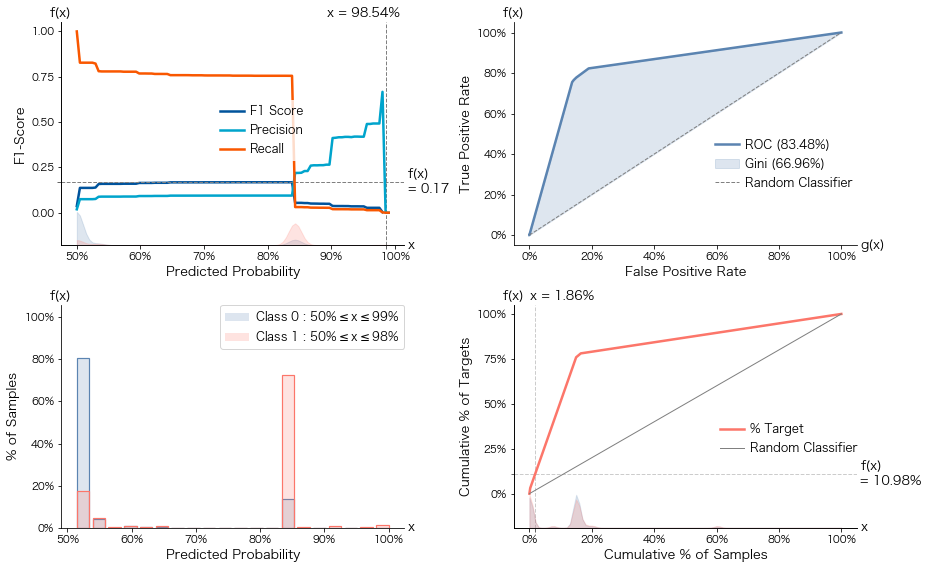

In [86]:
ax = evaluation.plot_all(y_train, y_train_pred)

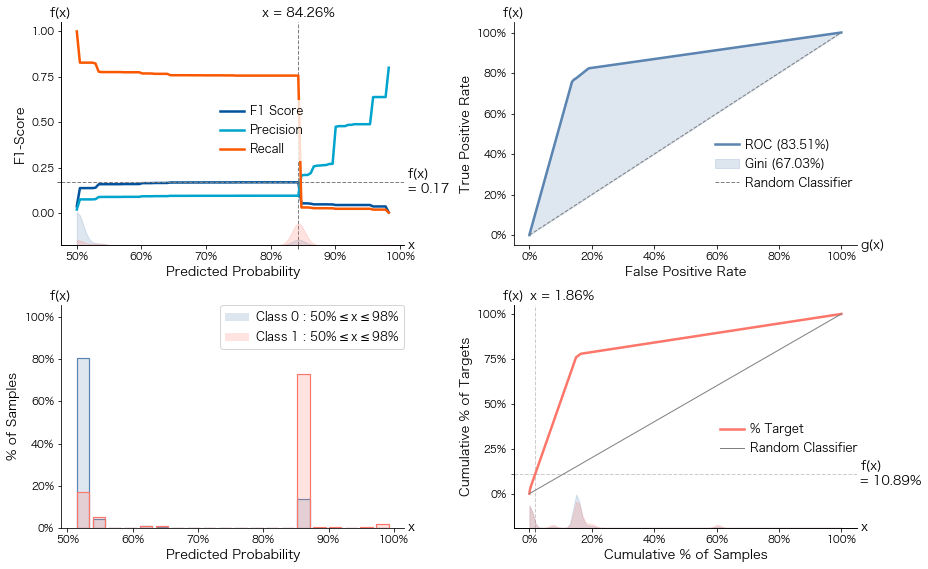

In [87]:
ax = evaluation.plot_all(y_test, y_test_pred)

In [51]:
# ax = evaluation.plot_all(y_oot, y_oot_pred)

In [88]:
t = 0.4
print("="*48)
print("(1) Train")
prec_recall(y_train, X_train.sum(1)>0, y_train_pred>=t)
print("-"*48)
print("(2) Test")
prec_recall(y_test, X_test.sum(1)>0, y_test_pred>=t)
print("-"*48)
print("(3) Out-Of-Time")
prec_recall(y_oot, X_oot.sum(1)>0, y_oot_pred>=t)
print("="*48)

(1) Train
Precision => Before :   1.86% , After :   1.86%
Recall    => Before : 100.00% , After : 100.00%
------------------------------------------------
(2) Test
Precision => Before :   1.86% , After :   1.86%
Recall    => Before : 100.00% , After : 100.00%
------------------------------------------------
(3) Out-Of-Time
Precision => Before :   6.44% , After :   6.44%
Recall    => Before : 100.00% , After : 100.00%


In [75]:
model.coef_

array([[-0.01510808, -0.01495618, -0.02870699, -0.02259248, -0.01674158,
        -0.02097438, -0.14711439, -0.06623119, -0.02192642, -0.0417858 ,
        -0.03937202, -0.02807953, -0.04178383,  0.00341185,  0.00341185,
        -0.01402305, -0.01222871, -0.00562055, -0.03599324,  0.01581358,
        -0.01744222, -0.01926334, -0.12094826,  0.00341185,  0.00341185]])

In [50]:
alpha = model.intercept_[0]
alpha

-1.5559133928081017

In [ ]:
model.coef_.ravel()[5]

In [ ]:
new_features[5]

In [54]:
_, factor, offset = cal_score(y_train_pred)

In [ ]:
63.3664

In [ ]:
mapping['ECOM045.2']

In [57]:
(-235.2201 * -0.013423222364079482 + alpha/len(used_features)) * factor * offset/len(used_features)

888.589356930746

In [ ]:
score = -(a['coef'].astype(float) * a['woe'] + incpt) * self.factor + offset

In [ ]:
alpha

In [76]:
for f in used_features:
    print(f," ==> ",mapping[f])

ECOM058.2  ==>  {0: 0, 1: -305.8311}
ECOM045.2  ==>  {0: 0, 1: -235.2201}
ECOM018.2  ==>  {0: 0, 1: -69.8846}
ECOM020.2  ==>  {0: 0, 1: -54.2953}
ECOM003  ==>  {0: 0, 1: -193.6248}
ECOM029.2  ==>  {0: 0, 1: -115.2272}
ECOM038.2  ==>  {0: 0, 1: -11.3672}
ECOM057.2  ==>  {0: 0, 1: -27.3814}
ECOM034.2  ==>  {0: 0, 1: -128.2103}
ECOM066.2  ==>  {0: 0, 1: -48.6441}
ECOM023.2  ==>  {0: 0, 1: -47.6846}
ECOM063.2  ==>  {0: 0, 1: -85.862}
ECOM035.2  ==>  {0: 0, 1: -48.3369}
ECOM076.2  ==>  {0: 0, 1: -396.7681}
VVIP_Broad_001.2  ==>  {0: 0, 1: -396.7681}
ECOM074.2  ==>  {0: 0, 1: -386.3541}
PGW0034.2  ==>  {0: 0, 1: -227.5128}
ECOM019.2  ==>  {0: 0, 1: -246.3603}
ECOM024.2  ==>  {0: 0, 1: -31.3259}
CSTWS001.2  ==>  {0: 0, 1: -44.132}
ECOM059.2  ==>  {0: 0, 1: -209.5879}
ECOM010.R  ==>  {0: 0, 1: -168.0023}
ECOM010.2  ==>  {0: 0, 1: -13.9267}
EDC0081DB  ==>  {0: 0, 1: -396.7681}
EDC0087DB  ==>  {0: 0, 1: -396.7681}


In [38]:
np.log(0.01/0.5)

-3.912023005428146

In [36]:
mapping

{'ECOM058.2': {0: 0, 1: 0},
 'ECOM045.2': {0: 0, 1: 0},
 'ECOM039.2': {0: 0, 1: 328.6497},
 'ECOM018.2': {0: 0, 1: 0},
 'ECOM020.2': {0: 0, 1: 0},
 'ECOM037.2': {0: 0, 1: 63.3664},
 'ECOM003': {0: 0, 1: 0},
 'ECOM029.2': {0: 0, 1: 0},
 'ECOM049.2': {0: 0, 1: 178.2466},
 'ECOM001.2': {0: 0, 1: 52.4297},
 'ECOM056.2': {0: 0, 1: 98.9805},
 'ECOM016.2': {0: 0, 1: 18.6665},
 'ECOM039.4': {0: 0, 1: 215.8096},
 'ECOM038.2': {0: 0, 1: 0},
 'ECOM057.2': {0: 0, 1: 0},
 'ATM0010': {0: 0, 1: 49.8227},
 'ECOM034.2': {0: 0, 1: 0},
 'ECOM066.2': {0: 0, 1: 0},
 'ECOM070.2': {0: 0, 1: 33.0964},
 'ECOM023.2': {0: 0, 1: 0},
 'ECOM064.2': {0: 0, 1: 78.0825},
 'ECOM040.2': {0: 0, 1: 104.2954},
 'ECOM002.2': {0: 0, 1: 215.4812},
 'ECOM063.2': {0: 0, 1: 0},
 'ECOM035.2': {0: 0, 1: 0},
 'ECOM076.2': {0: 0, 1: 0},
 'ECOM046.2': {0: 0, 1: 107.5714},
 'ECOM042.2': {0: 0, 1: 76.6845},
 'VVIP_Broad_001.2': {0: 0, 1: 0},
 'ECOM043.2': {0: 0, 1: 245.0684},
 'ECOM074.2': {0: 0, 1: 0},
 'ECOM060.2': {0: 0, 1: 125.8066

In [62]:
1 / (1 + np.exp(-(0.1 + 0.5*0.2)))

0.549833997312478

In [89]:
2898/5690

0.5093145869947276